# ARIMA Modeling of Seasonal Flu 
**Steven Hayden, Kevin Mendosna, Joseph Schueder, and Nicole Wittlin**

## Introduction/Overview

The COVID-19 Pandemic has taken an unprecedented toll on our country's health systems, and as the US prepares for an upcoming influenza season this fall, it is critical to prepare and enable our providers with all the information and equipment necessary. To that end, officials at the Strategic National Stockpile have asked our team to assist them in projecting the flu season in the upcoming few years. This will help the agency determine how to replenish the stockpile with flu season in mind.

We have partnered with the Center for Disease Control (CDC) Influenza Division for data, as the CDC collects, compiles, and analyzes data on influenza virus activity year-round in the United States. Annual influenza surveillance entails voluntary reporting by public health partners and health-care providers about which virus strains are circulating when and where. Data is reported weekly, Sunday through Saturday, and "flu season" usually begins around October and peaks from December to February, sometimes remaining elevated until May. As a result, the start date each year is around week 40 and ends 39 of the subsequent year. For example, the 2019-2020 flu season began September 29, 2019 and will end September 26, 2020. 

Given the seasonal nature of the influenza virus, the most appropriate analysis methods are for time series, which seek to extract meaningful statistics and other data characteristics in relation to defined time periods. These methods are used to analyze "non-stationary data" such as weather data, economic data, retail data, and other time-defined datasets. Since time series data are time dependent, observations are not independent, likely have some increasing or decreasing overall trend, and have a seasonality trend. The specific aspects direct how the analysis should be conducted.   

## Data Preparation (Q1)

Our team retrieved the data from the CDC's FluView Interactive online application that houses weekly flu surveillance data. Typically, the data is received from several sources, including public health labs, clinical labs, and outpatient healthcare providers. All reports include the number of specimens tested and the number of positive cases, plus age/age group if available. The approximately 100 reporting public health labs also test for virus types and subtypes and report on the lineages circulating among which age groups. Clinical labs primarily test for diagnostic purposes to determine timing and intensity of flu activity. The 300 labs commonly report number of specimens tested, number positive, and number positive of each type. Combined these two sources compose the World Health Organization Collaborating Laboratories System and National Respiratory and Enteric Viruc Surveillance Systems (WHO/NREVSS). A third source of data comes from outpatient healthcare providers in all 50 states, Puerto Rico, DC, and the US Virgin Islands that report "influenza-like illness," which are a fever plus cough and/or sore throat. This ILINet data combines state-specific data weighted by state population. 

Our team elected to use the WHO/NREVSS data from public and clinical labs, so we combined this data into one dataset with year, week, specimens tested, specimens positive, and details about specific strains. The CDC noted that for efficiency, public health labs often receive samples that have already tested positive in a clinical lab. Thus, we acknowledge there may a higher positive percentage in the data. This over-estimation would lead to more supplies needed, rather than less, so we feel this duplication will not negatively impact our analysis. Additionally, we elected to not use the "influenza-like" ILINet data since it does not directly confirm a tested specimen.


### Exploratory Data Analysis 

**SOMEWHERE EXPLAIN THAT DATA SET GOES FROM 1997 to 2020 but we are using 2015 - 2019 for initial analysis, will expand as needed.**


We downloaded data from the https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html which included two separate datasets.  The WHO_NREVSS Clinical Labs data set included the period from 2015 week 40 through 2020 week 25. The ILINet data set included data from 1997 through 2020, but while expansive did not include positive case count but rather just visits by patients experiencing influenza like illness categorized by age bins.  Therefore, we used just the WHO_NREVSS Clinical Labs data set from 2015 through 2020.  Furthermore, due to the COVID-19 anomaly in the 2019/2020 flu season, we limited our analysis to the data from the 2015 to the 2018/2019 cycle. The start date of flu season each year is approximate, so we elected to conduct our analysis with a time window from July 1 to June 30. This captures any seasonality in the data and is also consistent from year to year.

We leveraged the Pandas Profiling package for our EDA and osme fo tghe results are shown below.  We also saved a copy to html for further reference.

**MISSING DATA:**
We initially attempted to use Regional data but found a lot of missing data whihc made analysis difficult and hard to compare across regions.  We therefore elected to use the national data that did not have any missing data. 

**VARIABLES:** 
There are 4 variables in the data set:
- df_index
- Year
- Week
- PositiveCases

| Number of variables 	| 4 	|
|-	|-	|
| Number of observations 	| 260 	|
| Missing cells 	| 0 	|
| Missing cells (%) 	| 0.0% 	|
| Duplicate rows 	| 0 	|
| Duplicate rows (%) 	| 0.0% 	|

In [1]:
import warnings
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm


In [2]:
# National level data
dfx = pd.read_csv(r'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%204/NationalCombined_UpTo_2020.csv')    

In [3]:
dfx.head()

,Year,Week,PositiveCases
0,1997,40,0
1,1997,41,11
2,1997,42,17
3,1997,43,7
4,1997,44,10


In [4]:
dfx.tail()

,Year,Week,PositiveCases
1180,2020,20,48
1181,2020,21,17
1182,2020,22,14
1183,2020,23,21
1184,2020,24,10


In [5]:
dfx.describe()

,Year,Week,PositiveCases
count,1185.000000,1185.000000,1185.000000
mean,2008.596624,26.519831,1560.747679
std,6.570896,15.142169,3653.877099
min,1997.000000,1.000000,0.000000
25%,2003.000000,13.000000,23.000000
50%,2009.000000,26.000000,207.000000
75%,2014.000000,40.000000,1173.000000
max,2020.000000,53.000000,26386.000000


In [6]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 3 columns):
Year             1185 non-null int64
Week             1185 non-null int64
PositiveCases    1185 non-null int64
dtypes: int64(3)
memory usage: 27.9 KB


In [39]:
#!python -m pip install --upgrade pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(dfx, plot={'histogram': {'bins': 8}}, explorative=True)
profile.to_notebook_iframe()
profile.to_file("FluData_EDA_Report.html")

In [7]:
dfx['Date'] = pd.to_datetime(dfx.Year.astype(str), format='%Y') + \
             pd.to_timedelta(dfx.Week.mul(7).astype(str) + ' days')

# created this column so the rest of the code did not need to be replaced. 
dfx['COUNT POSITIVE']=dfx['PositiveCases']

Set up annual analysis from July 1 to June 30. We acknowledge that this does not directly correspond to approximate flu season dates but believe it still captures seasonality and provides more consistency.

In [8]:
# Set up July 1 to June 30 time frame
dfx = dfx.loc[dfx['Date'] >= '2015-07-01' ]
dfx = dfx.loc[dfx['Date'] < '2020-07-01']

In [9]:
dfx

,Year,Week,PositiveCases,Date,COUNT POSITIVE
926,2015,26,129,2015-07-02,129
927,2015,27,99,2015-07-09,99
928,2015,28,86,2015-07-16,86
929,2015,29,73,2015-07-23,73
930,2015,30,73,2015-07-30,73
931,2015,31,93,2015-08-06,93
932,2015,32,81,2015-08-13,81
933,2015,33,98,2015-08-20,98
934,2015,34,100,2015-08-27,100
935,2015,35,139,2015-09-03,139


In [10]:
dfx['Date'].min(), dfx['Date'].max()

(Timestamp('2015-07-02 00:00:00'), Timestamp('2020-06-17 00:00:00'))

In [11]:
#Check for Missing Values
dfx = dfx.sort_values('Date')
dfx.isnull().sum()

Year              0
Week              0
PositiveCases     0
Date              0
COUNT POSITIVE    0
dtype: int64

In [12]:
dfx2 = dfx.groupby('Date')['COUNT POSITIVE'].sum().reset_index()
dfx2

,Date,COUNT POSITIVE
0,2015-07-02,129
1,2015-07-09,99
2,2015-07-16,86
3,2015-07-23,73
4,2015-07-30,73
5,2015-08-06,93
6,2015-08-13,81
7,2015-08-20,98
8,2015-08-27,100
9,2015-09-03,139


## Indexing with Time Series Data
With the exploratory data analysis complete, we need to index the data before proceeding with our analysis. Given the nature of this time series flu data, we need to be able to conduct weekly analysis. The indexing process will allow us to compare week to week through the season and week to week across the years in the sample. Note, unlike numeric indexing where the end index is usually not included, here the end index **is** included. Indices also have to be sorted in order and should not be randomized. 

In [13]:
dfx2.index = pd.DatetimeIndex(dfx2.Date).to_period('W')
dfx2.index

PeriodIndex(['2015-06-29/2015-07-05', '2015-07-06/2015-07-12',
             '2015-07-13/2015-07-19', '2015-07-20/2015-07-26',
             '2015-07-27/2015-08-02', '2015-08-03/2015-08-09',
             '2015-08-10/2015-08-16', '2015-08-17/2015-08-23',
             '2015-08-24/2015-08-30', '2015-08-31/2015-09-06',
             ...
             '2020-04-13/2020-04-19', '2020-04-20/2020-04-26',
             '2020-04-27/2020-05-03', '2020-05-04/2020-05-10',
             '2020-05-11/2020-05-17', '2020-05-18/2020-05-24',
             '2020-05-25/2020-05-31', '2020-06-01/2020-06-07',
             '2020-06-08/2020-06-14', '2020-06-15/2020-06-21'],
            dtype='period[W-SUN]', name='Date', length=259, freq='W-SUN')

Review the Flu data from the 2015/2016 flu season through the 2018/2019 flu season

In [14]:
y=dfx2['COUNT POSITIVE']

In [15]:
y

Date
2015-06-29/2015-07-05      129
2015-07-06/2015-07-12       99
2015-07-13/2015-07-19       86
2015-07-20/2015-07-26       73
2015-07-27/2015-08-02       73
2015-08-03/2015-08-09       93
2015-08-10/2015-08-16       81
2015-08-17/2015-08-23       98
2015-08-24/2015-08-30      100
2015-08-31/2015-09-06      139
2015-09-07/2015-09-13      148
2015-09-14/2015-09-20      198
2015-09-21/2015-09-27      167
2015-09-28/2015-10-04      202
2015-10-05/2015-10-11      209
2015-10-12/2015-10-18      228
2015-10-19/2015-10-25      223
2015-10-26/2015-11-01      208
2015-11-02/2015-11-08      210
2015-11-09/2015-11-15      270
2015-11-16/2015-11-22      250
2015-11-23/2015-11-29      268
2015-11-30/2015-12-06      316
2015-12-07/2015-12-13      348
2015-12-14/2015-12-20      577
2015-12-21/2015-12-27      552
2015-12-28/2016-01-03      724
2016-01-04/2016-01-10      960
2016-01-11/2016-01-17     1275
2016-01-18/2016-01-24     1658
                         ...  
2019-11-25/2019-12-01     4600
201

In [16]:
dfx.head()

,Year,Week,PositiveCases,Date,COUNT POSITIVE
926,2015,26,129,2015-07-02,129
927,2015,27,99,2015-07-09,99
928,2015,28,86,2015-07-16,86
929,2015,29,73,2015-07-23,73
930,2015,30,73,2015-07-30,73


## Analysis

### Visualize Time Series Data
The first step in time series analysis is to visualize the data. This will initially reveal if the data has "seasonal peaks" (patterns that recur in a specific time frame) and whether the data has an overall upward or downward trend over time. Combined, these to characteristics will indicate if the data has "stationarity." Stationary data is an assumption for time series models and reflects constant statistical properties of mean and variance over time.

Our first visual analysis, the Flu Cases over Time cart below, reveals several key points about stationarity. First, **the observations look seasonal, with peaks of flu cases occurring just after each new year.** Also, the **the peaks each year appear to trend upward.** Both of these indicate that this is not stationary data.


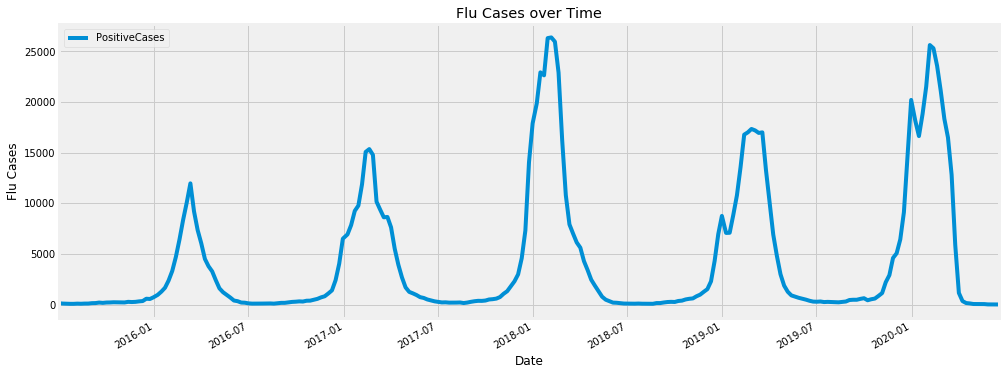

In [17]:
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
dfx3 = dfx[['Date','PositiveCases']].copy()
dfx3 = dfx3.set_index('Date')
dfx3.plot(figsize=(15, 6))
plt.ylabel('Flu Cases')
plt.title('Flu Cases over Time')
y3=dfx3['PositiveCases']
plt.show()

The next visual check to be done using a method called **"time-series decomposition"**, which allows us to separate our time series data into three distinct components: trend, seasonality, and noise. The chart below shows four panels: observed data, trend data, seasonal component, and residuals.

Visual analysis of the decomposition graphs illuminate several, additional key points about our time series data set. The top chart, of *observed data*, puts the realization chart in alignment by time with the trend, seasonal, and residuals. With the components separated, the second chart *trend* indicates an increase over time by looking at the moving average. The third chart *seasonality* removes the trend from the observations, so the peaks can be compared with each other and their intervals. We can see that the peaks are consistently happening early in the year. This supports our initial assumption that this is non-stationary data. For Stationary data, the residual plot should appear random.


In [18]:
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq = 52)


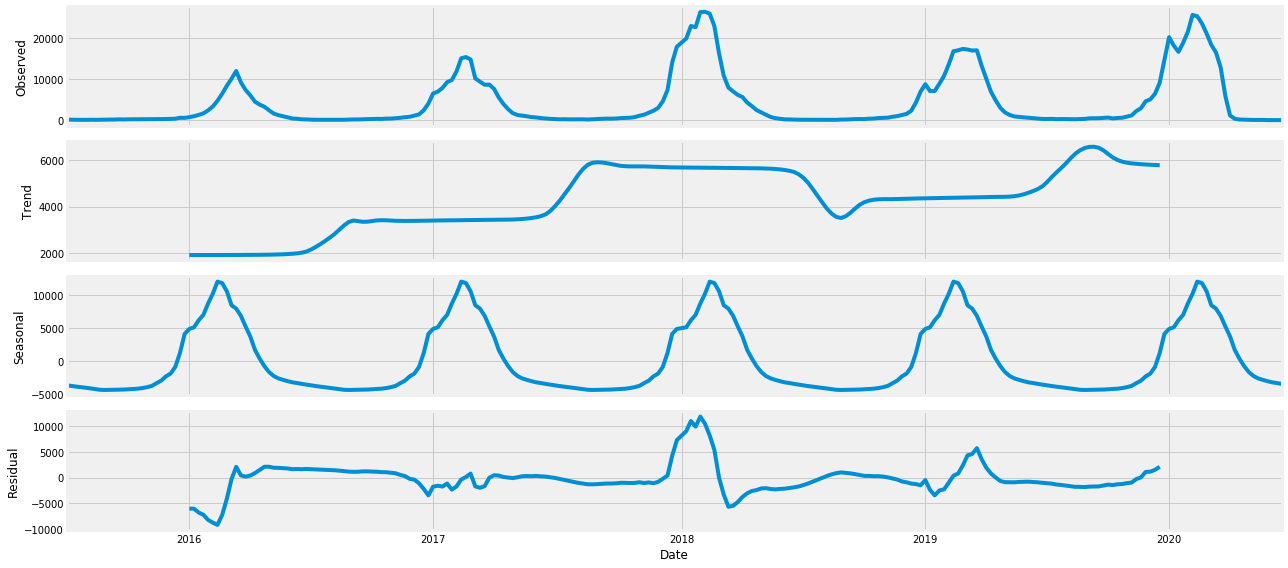

In [19]:
import warnings
warnings.filterwarnings('ignore')
fig = decomposition.plot()
plt.show()

We conduct one final plot of the Autocorrelation of the data. From the chart below, it appears our data displays serial autocorrelation as there is correlation between many lags of the data. While this would suggest the data may need to be modified before conducting an ARIMA time series analysis, we will run the Dickey-Fuller test to confirm.

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, second):
    
    #Determing rolling statistics
    rolmean = second.rolling(52).mean()
    rolstd = second.rolling(52).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20, 4))
    orig = plt.plot(second, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Text(0.5, 1.0, 'Autocorrelation Function')

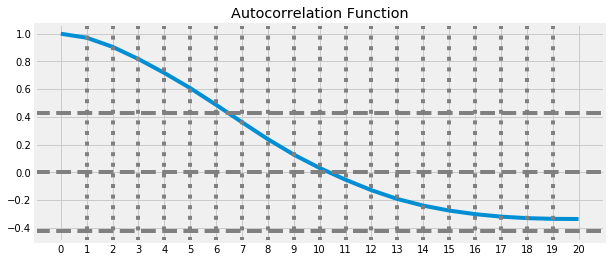

In [21]:
from statsmodels.tsa.stattools import acf, pacf
acf_dif_y = acf(y.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_dif_y)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_dif_y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_dif_y)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

The Dickey-Fuller test can statistically confirm the stationarity of our data. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
- **Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- **Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Note: the p-values are obtained through regression surface approximation from MacKinnon 1994, but we used the updated 2010 tables. If the p-value is close to the significance level, then the critical values should be used to judge whether to reject the null hypothesis.

The results of the Dickey-Fuller test on the baseline seasonal flu data reject the Null Hypothesis (p-value = 0.000059) and indicates there is not sufficient evidence to confirm the data has a time dependent structure. Statistically, our data may have proven to be stationary; however, given our understanding of the flu as a seasonal virus, we opt to try additional techniques to transform our data to see if there is any change in results.  

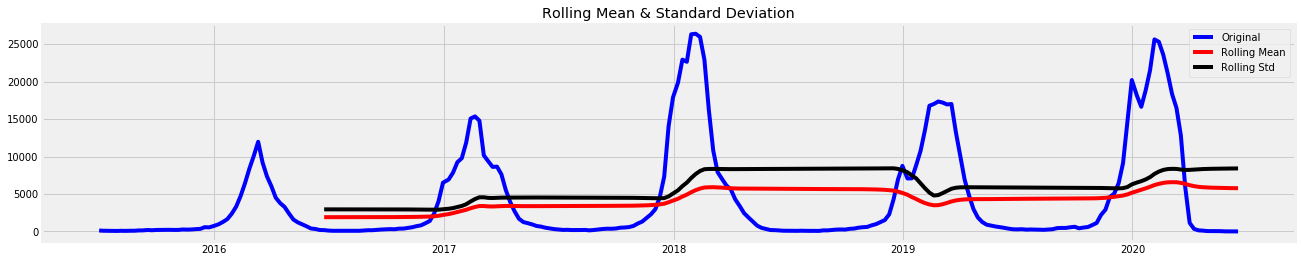

Results of Dickey-Fuller Test:
Test Statistic                  -4.782835
p-value                          0.000059
#Lags Used                       6.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [22]:
test_stationarity(y.dropna(),y3.dropna())

### Data Transformation - Shift
To improve the stationarity of the data, we can do a transformation by shifting the data by one week. This is helpful for lag correlated data. The Dickey-Fuller test again rejects the null hypothesis on the shifted data (p-value = 0.000059) and indicates stationary data. However, we will try one additional transformation technique to see if there are any changes.  

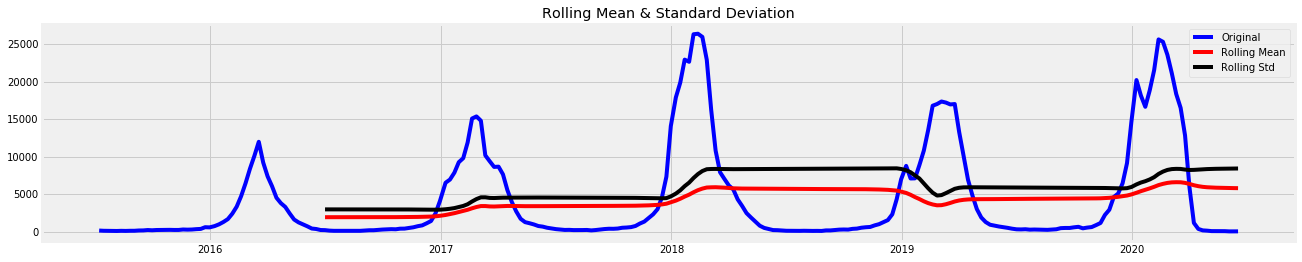

Results of Dickey-Fuller Test:
Test Statistic                  -4.781278
p-value                          0.000059
#Lags Used                       6.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [23]:
# we difference the data here and fit the model on this dataset but also keep the un-differenced data 

from statsmodels.tsa.stattools import adfuller

dif_y=y.shift(1)
dif_y3 =y3.shift(1)
test_stationarity(dif_y.dropna(),dif_y3.dropna())

### Data Transformation - Differencing
Next, we transform the data by differencing. This transformation method can remove the dependence on time and stabilize the mean. Again, the results of the Dickey-Fuller test on the differenced data reject the null hypotheses. The results are slightly worse than our previous two tests (p-value = 0.000272). We will proceed with our analysis using the original data.  

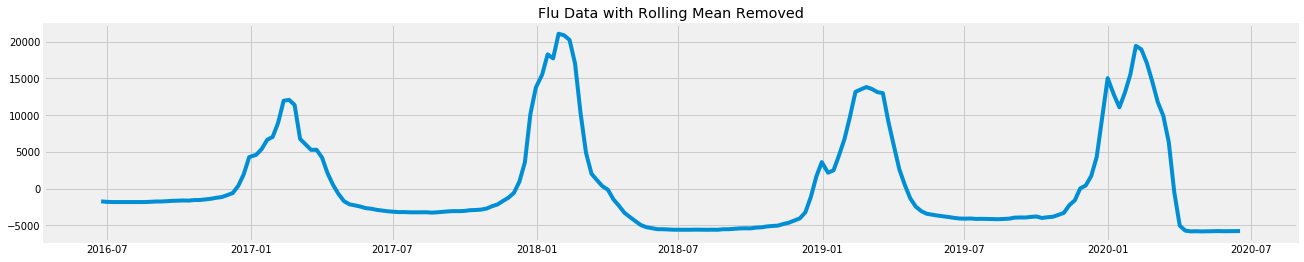

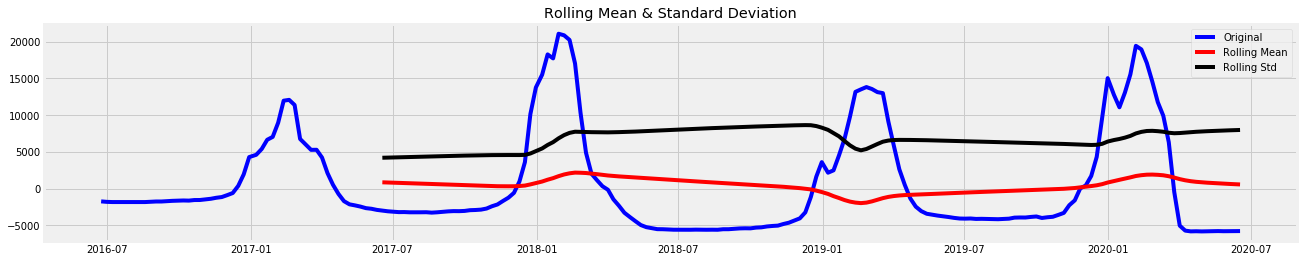

Results of Dickey-Fuller Test:
Test Statistic                  -4.421515
p-value                          0.000272
#Lags Used                       6.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [24]:
moving_avg = y.rolling(52).mean()
moving_avg3 = y3.rolling(52).mean()
no_trend = y - moving_avg
no_trend3 = y3 - moving_avg3
plt.figure(figsize=(20, 4))
plt.plot(no_trend3)
plt.title("Flu Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna(), no_trend3.dropna())

With the results from the Dickey-Fuller tests coming back as stationary, yet our visuals show non-stationary data, we need to ask *does this make sense?* This is where our subject matter expertise comes into play. We know that flu peaks between December and February. The visualizations show peaks consistently early each year. We also see that during the summer months, there are zero cases reported. During those months, the values do not fluctuate with time. This could be what is driving the results of the Dickey-Fuller test to show stationarity. For those reasons, **we opted to proceed with modeling the data as non-stationary.** 

### Optimal Parameters: Plot ACF and PACF 

To begin the process of building our ARIMA model, we start with exploring parameters. We will look at the **Autocorrelation Function (ACF)** and the **Partial Autocorrelation Function (PACF)** to determine optimal values for select parameters.

The **ACF** measures the correlation between the time series data and a lagged version of itself, or stated another way it measures the correlation between time series observations separated by *k* time units. The  **PACF** measures correlation between time series data and a lagged version of itself *after* eliminating variations already explained above (i.e. seasonality and trend). It measures the strength of the relationship of data with the other terms being accounted for.

Below, we plot the ACF and PACF for each data set (no transformation, shifted data, and differenced data). Looking at the plots together show signs of *wandering behavior* as the lags slowly decrease. The PACF plots suggest to difference the data. Once the data is differentiated, it does provide more information about a potential order of two for the AR component, as we see the first signficant change of direction after two lags in the PACF plots. 

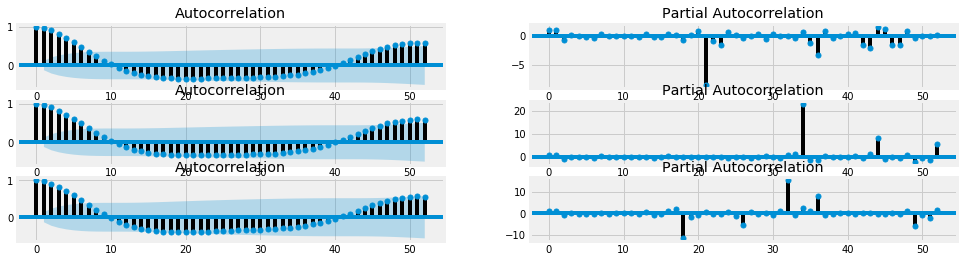

In [25]:
# Graph data
fig, axes = plt.subplots(3, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(y.dropna(), lags=52, ax=axes[0,0])
fig = sm.graphics.tsa.plot_pacf(y.dropna(), lags=52, ax=axes[0,1])
fig = sm.graphics.tsa.plot_acf(dif_y.dropna(), lags=52, ax=axes[1,0])
fig = sm.graphics.tsa.plot_pacf(dif_y.dropna(), lags=52, ax=axes[1,1])
fig = sm.graphics.tsa.plot_acf(no_trend.dropna(), lags=52, ax=axes[2,0])
fig = sm.graphics.tsa.plot_pacf(no_trend.dropna(), lags=52, ax=axes[2,1])

### Build ARIMA Model (Q2)

One of the most commonly used methods for time series forecasting is ARIMA, which stands for an Autoregressive Integrated Moving Average model. To fully understand ARIMA, it can be broken down into three components that align with the parameters of the model that correspond to seasonality, trend, and noise in the data. 

- **AR** stands for Autoregressive, which means that the current predictions depend on past results in the form of lags on the dependent variable; this parameter, represented by **p**, uses the dependent relationship between observations and lagged observations. **p** denotes the number of lags or the lag order of the model. One way to define p is to observe where the PACF plot crosses the upper confidence interval for the first time.
- **I** stands for integrated, which considers how to difference the raw data to improve stationarity. This parameter is represented by **d**, the number of times the data observations are differenced; also known as the degree of differencing.
- **MA** stands for Moving Average and takes into account previous results, nonseasonal differences, and the dependency between observations and residuals. Essentially, it compares a moving window of observations to lagged observations. Represented in the model by **q**, it is the order (or size) of the moving average. One way to define q is to observe where the ACF crosses the upper confidence interval for the first time. 

A major assumption of the ARIMA model is stationarity in the data, meaning that no trend or seasonality is present. With our data, we felt it was more appropriate to model as if it were not stationary (despite the results of the Dickey-Fuller tests). Therefore, we are going to use a **SARIMA** model (seasonal ARIMA), **which helps to estimate the model more accurately than ARIMA because SARIMA has better tolerance for estimation models when non-stationary data is provided.** 


**HOW ARE SARIMA parameters different than ARIMA parameters?**
SARIMA adds three new hyperparameters for the seasonal component of the series to specify:
* the autoregression (AR), 
* differencing (I)
* moving average (MA) 

An additional parameter for the period (m) of the seasonality is also added. An *m* of 52 for weekly data suggests a yearly seasonal cycle. Seasonal ARIMA models can potentially have a large number of parameters and combinations of terms. Therefore, it is appropriate to try out a wide range of models when fitting to data and choose the best fit.

To do this, we utilized a Grid Search to try all combinations of parameters and terms. The full results can be found here:
**[LINK TO EXCEL FILE]**. We are looking for the lowest AIC value, which stands for the Akaike information criterion. It aids in model selection by estimating an out-of-sample prediction error and providing context for model quality. A lower AIC is better.

In [28]:
# need to see if we can get this to iterate 
p = range(3, 7)
d = range(0, 3)
q = range(0, 3)

#pdq = list(itertools.permutations(p, d, q),3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [29]:
#list([list(p),list(d),list(q)])
seasonal_pdq

[(3, 0, 0, 52),
 (3, 0, 1, 52),
 (3, 0, 2, 52),
 (3, 1, 0, 52),
 (3, 1, 1, 52),
 (3, 1, 2, 52),
 (3, 2, 0, 52),
 (3, 2, 1, 52),
 (3, 2, 2, 52),
 (4, 0, 0, 52),
 (4, 0, 1, 52),
 (4, 0, 2, 52),
 (4, 1, 0, 52),
 (4, 1, 1, 52),
 (4, 1, 2, 52),
 (4, 2, 0, 52),
 (4, 2, 1, 52),
 (4, 2, 2, 52),
 (5, 0, 0, 52),
 (5, 0, 1, 52),
 (5, 0, 2, 52),
 (5, 1, 0, 52),
 (5, 1, 1, 52),
 (5, 1, 2, 52),
 (5, 2, 0, 52),
 (5, 2, 1, 52),
 (5, 2, 2, 52),
 (6, 0, 0, 52),
 (6, 0, 1, 52),
 (6, 0, 2, 52),
 (6, 1, 0, 52),
 (6, 1, 1, 52),
 (6, 1, 2, 52),
 (6, 2, 0, 52),
 (6, 2, 1, 52),
 (6, 2, 2, 52)]

### Model Selection
The Grid Search results returned two models with an AIC of 8.0: ARIMA(0, 0, 0)x(3, 1, 0, 52) and ARIMA(0, 1, 0)x(3, 1, 0, 52). A snapshot of the Grid Search results is included below, but we use the full output to identify our final model. 

After thorough review, we selected a model with an AIC of 10.0. This is not significantly higher than the optimal model, and we opted to use different parameters given the uncertaintly of our data with many weeks of zero flu cases reported. The model we ultimately selected is:

**ARIMA(0, 1, 1)x(3, 1, 0, 52)**

- The AR of 0 indicates that we did not model with a lag in the data.
- The I of 1 indicates that we did difference the data by one degree.
- The MA of 1 indicates that we did use a moving average of one. 

For the SARIMA parameters, we used the following values related to seasonality:

- The AR of 3 indicates an order of lag 3 for the seasonal component.
- The I of 1 indicates a difference in the data by one degree for the season component.
- The MA of 0 indicates we did not model with a moving average for the seasonal component.
- The *m* parameter value of 52 indicates a time period of 52 weeks.  

We believe this model balances the low AIC value with parameters that will not overfit to the data. Since we have uncovered anomolies in the data with the weeks of zero cases, we wanted to make sure that those weeks weren't overly influencing the model and overshawdowing the seasonal peaks. Fitting and evaluating the model below will confirm the validity of our thinking.

In [33]:
%%time
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
df = pd.DataFrame(columns=['param', 'param_seasonal', 'resultsaic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(no_trend.dropna(),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
 #           df.append({'param': param, 'param_seasonal': param_season, 'resultsaic': results.aic}, ignore_index=True)
        except:
            continue
            
#            df = pd.DataFrame('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(3, 0, 0)x(3, 0, 0, 52)52 - AIC:14.0
ARIMA(3, 0, 0)x(3, 0, 1, 52)52 - AIC:16.0
ARIMA(3, 0, 1)x(3, 0, 0, 52)52 - AIC:16.0
ARIMA(3, 0, 1)x(3, 0, 1, 52)52 - AIC:18.0
ARIMA(3, 0, 2)x(3, 0, 0, 52)52 - AIC:18.0
ARIMA(3, 0, 2)x(3, 0, 1, 52)52 - AIC:20.0
ARIMA(4, 0, 0)x(3, 0, 0, 52)52 - AIC:16.0
ARIMA(4, 0, 0)x(3, 0, 1, 52)52 - AIC:18.0
ARIMA(4, 0, 1)x(3, 0, 0, 52)52 - AIC:18.0
ARIMA(4, 0, 1)x(3, 0, 1, 52)52 - AIC:20.0
ARIMA(4, 0, 2)x(3, 0, 0, 52)52 - AIC:20.0
ARIMA(4, 0, 2)x(3, 0, 1, 52)52 - AIC:22.0
ARIMA(5, 0, 0)x(3, 0, 0, 52)52 - AIC:18.0
ARIMA(5, 0, 0)x(3, 0, 1, 52)52 - AIC:20.0
ARIMA(5, 0, 1)x(3, 0, 0, 52)52 - AIC:20.0
ARIMA(5, 0, 1)x(3, 0, 1, 52)52 - AIC:22.0
ARIMA(5, 0, 2)x(3, 0, 0, 52)52 - AIC:22.0
ARIMA(5, 0, 2)x(3, 0, 1, 52)52 - AIC:24.0
ARIMA(6, 0, 0)x(3, 0, 0, 52)52 - AIC:20.0
ARIMA(6, 0, 0)x(3, 0, 1, 52)52 - AIC:22.0
ARIMA(6, 0, 1)x(3, 0, 0, 52)52 - AIC:22.0
ARIMA(6, 0, 1)x(3, 0, 1, 52)52 - AIC:24.0
ARIMA(6, 0, 2)x(3, 0, 0, 52)52 - AIC:24.0
ARIMA(6, 0, 2)x(3, 0, 1, 52)52 - A

### Fitting the ARIMA model
It is a best practice to always run model diagnostics to investigate any unusual behavior.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3131      0.103      3.038      0.002       0.111       0.515
ar.S.L52      -0.0262      0.126     -0.208      0.835      -0.273       0.221
ar.S.L104      0.2842      0.148      1.915      0.055      -0.007       0.575
ar.S.L156      0.1230      0.116      1.065      0.287      -0.103       0.349
sigma2      1.329e+06   2.12e+05      6.261      0.000    9.13e+05    1.74e+06


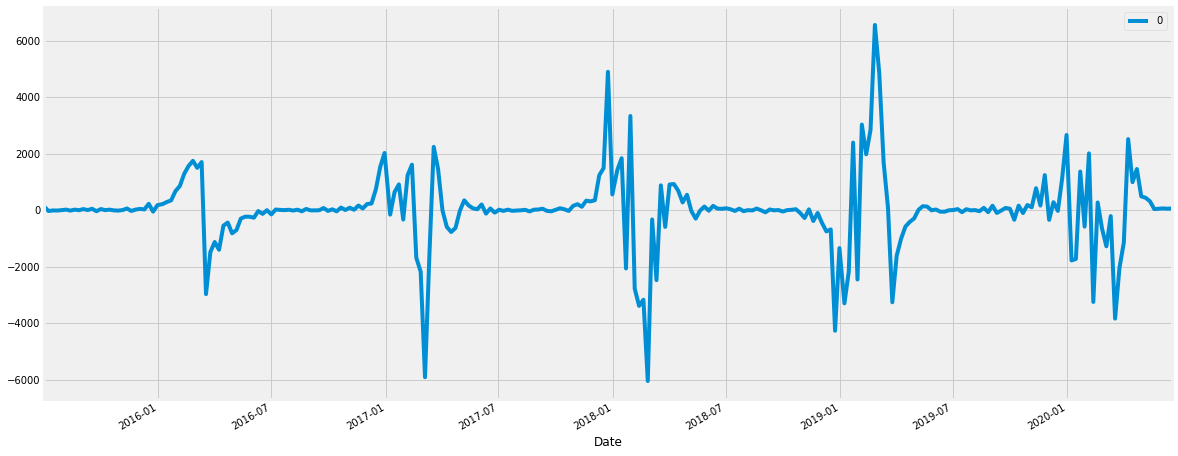

<Figure size 1440x288 with 0 Axes>

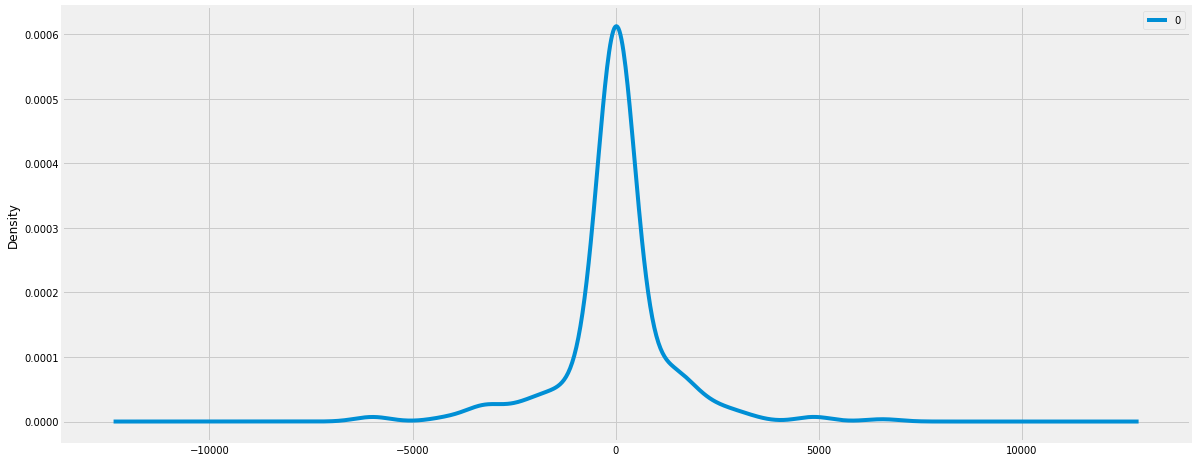

                 0
count   259.000000
mean     -0.661056
std    1310.395778
min   -6051.927805
25%     -91.657323
50%      12.700494
75%     167.116512
max    6561.552391


In [26]:
mod = sm.tsa.statespace.SARIMAX(y3,
                                order=(0, 1, 1),
                                seasonal_order=(3, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.figure(figsize=(20, 4))
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [27]:
from statsmodels.tsa.arima_model import ARIMA

In [28]:
residuals

,0
Date,
2015-07-02,129.000000
2015-07-09,-30.000000
2015-07-16,-9.250233
2015-07-23,-11.870356
2015-07-30,1.449107
2015-08-06,19.823097
2015-08-13,-14.419948
2015-08-20,18.760346
2015-08-27,-0.290210


In [29]:
print(results.plot_diagnostics)

<bound method MLEResults.plot_diagnostics of <statsmodels.tsa.statespace.sarimax.SARIMAXResults object at 0x0000014AB84446A0>>


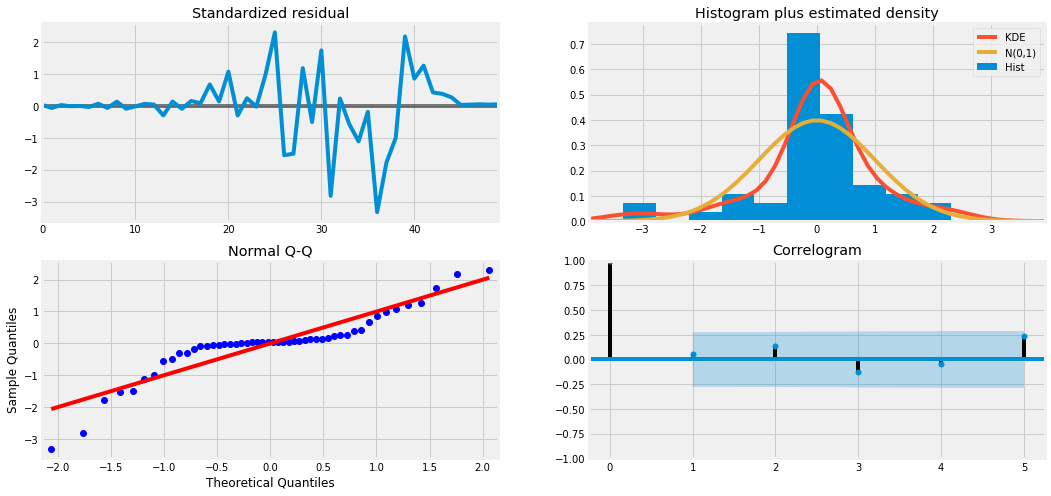

In [30]:
results.plot_diagnostics(lags=5, figsize=(16, 8))
plt.show()

The Standarized Residual chart shows the residuals evenly distributed above and below zero with out any pattern. While the residuals appear evenly distributed as a function of time (weeks), they do appear to be dependent on one another. The QQ plot and the histogram shows the distribution better. The residuals appear below the actuals more than they appear above. This does not mean we have a bad model, but it just suggests that there is room for improvement. In our forecasting, we should keep this in mind to ensure we are not underestimating. 

## Flu Season Forecast

### Validating forecasts (Q3)
To help us understand the accuracy of our forecasts, we compare predicted values to real values of the time series, and we set forecasts to start at the 2019-2020 season and extend into the next year. 

In [31]:
y_truth = y[150:]
y_truth

y_truth = pd.DataFrame(y_truth)
y_truth.head()

,COUNT POSITIVE
Date,
2018-05-21/2018-05-27,481
2018-05-28/2018-06-03,338
2018-06-04/2018-06-10,193
2018-06-11/2018-06-17,178
2018-06-18/2018-06-24,138


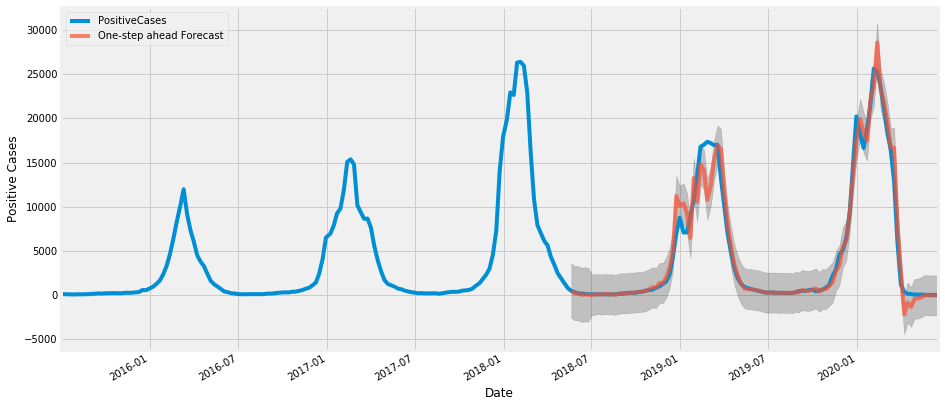

In [32]:
pred = results.get_prediction(start=150, dynamic=False)
pred_ci = pred.conf_int()
ax = dfx3.dropna().plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Positive Cases')
plt.legend()
plt.show()

The line plot shows the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values quite well, showing an upward trend that starts from the beginning of the year and captures the seasonality toward the end of the year.

In [33]:
# Forecast Evaluation

y_forecasted = pred.predicted_mean

y_forecasted2 = pd.DataFrame(y_forecasted)
y_forecasted2 = y_forecasted2.reset_index()
y_forecasted2.head()
y_forecasted2.index = pd.DatetimeIndex(y_forecasted2.Date).to_period('W')# just added this 

y_forecasted2 = y_forecasted2.rename(columns={0: 'prediction'})
y_forecasted2


y_truth = y[150:]
mse = ((y_forecasted2['prediction']- y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2028225.24


In [34]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1424.16



In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average weekly positive cases in the test set within **1424.16 of the real flu cases.** This will be closer to the units of measure. We believe this is this error seems acceptable give that this is across the entire population of the country.  Give that some weeks have 25,000+ cases a week, the apprimately 1,500 error spread across the country should have minimal impact for preparation.

## Conclusion

## References
- Our thanks to Kevin's nephew for assisting us with ARIMA modeling sample code from his work. 

Other articles and sources consulted:
- Unit 7 Class Slides
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.phe.gov/about/sns/Pages/default.aspx
- https://www.cdc.gov/flu/weekly/overview.htm
- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html#Cross-validation
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3  
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 
- https://towardsdatascience.com/introduction-to-aic-akaike-information-criterion-9c9ba1c96ced
- *Introductory Time Series with R* pages 143-144 (https://www.amazon.com/Introductory-Time-R-Use/dp/0387886974/ref=as_li_ss_tl?ie=UTF8&qid=1527719321&sr=8-1&keywords=introductory+time+series+with+r&linkCode=sl1&tag=inspiredalgor-20&linkId=235af99b9443823b7dcf05007a3ed7bb)

SARIMA References:
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- https://stackoverflow.com/questions/44235558/statespace-sarimax-model-why-the-model-use-all-the-data-to-train-mode-and-pred 
- https://medium.com/datadriveninvestor/time-series-prediction-using-sarimax-a6604f258c56